Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Typically symptoms include some combination of productive or dry cough, chest pain, fever, and trouble breathing.Severity is variable.

Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications and conditions such as autoimmune diseases. Risk factors include other lung diseases such as cystic fibrosis, COPD, and asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke, or a weak immune system.Diagnosis is often based on the symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.

The goal is to build a pneumonia detection system, to locate the position
of inflammation in an image.
Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and
appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the
image.
While we are theoretically detecting “lung opacities”, there are lung opacities that are not
pneumonia related.

The objective o the project is to:

1.   Learn to how to do build an Object Detection Model
2.   Use transfer learning to fine-tune a model
3.   Learn to set the optimizers, loss functions, epochs, learning rate, batch size, check-pointing, early stopping etc.
4.   Read different research papers of given domain to obtain the knowledge of advanced models for the given problem.

In [0]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 

#### Mount Google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

ERROR! Session/line number was not unique in database. History logging moved to new session 62
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### Change current working directory to project folder

In [0]:
import os
#### Add your code here ####
os.chdir('/content/drive/My Drive/PGP-AIML-UT-Austin-Jun19/Capstone Project/Kaggle - Dataset')

# - Extract Kaggle Dataset

In [0]:
import zipfile
with zipfile.ZipFile('rsna-pneumonia-detection-challenge.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/My Drive/PGP-AIML-UT-Austin-Jun19/Capstone Project/Kaggle - Dataset')

In [0]:
pip install pydicom

     |████████████████████████████████| 35.3MB 90kB/s 


In [0]:
import glob, pylab, pandas as pd
import pydicom, numpy as np

In [0]:
!ls

rsna-pneumonia-detection-challenge  rsna-pneumonia-detection-challenge.zip


In [0]:
os.chdir('/content/drive/My Drive/PGP-AIML-UT-Austin-Jun19/Capstone Project/Kaggle - Dataset/rsna-pneumonia-detection-challenge')

In [0]:
df = pd.read_csv('stage_2_train_labels.csv')
print(df.iloc[16])

patientId    00c0b293-48e7-4e16-ac76-9269ba535a62
x                                             306
y                                             544
width                                         168
height                                        244
Target                                          1
Name: 16, dtype: object


Medical images are stored in a special format known as DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.

In [0]:
patientId = df['patientId'][0]
dcm_file = 'stage_2_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

Most of the standard headers containing patient identifable information have been anonymized so we are left with a relatively sparse set of metadata. The primary field we will be accessing is the underlying pixel data:

In [0]:
im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


## Considerations
As we can see here, the pixel array data is stored as a Numpy array. In addition, it is apparent here that the original radiographs have been preprocessed for us as follows:

The relatively high dynamic range, high bit-depth original images have been rescaled to 8-bit encoding (256 grayscales). To visually assess the quality of the automated bit-depth downscaling and for considerations on potentially improving this baseline, consider consultation with a radiologist physician.

The relativley large original image matrices (typically acquired at >2000 x 2000) have been resized to the deimensions of 1024 x 1024. To visually assess the feasibility of diagnosis at this resolution, and to determine the optimal resolution for pneumonia detection.

# Visual Example

(-0.5, 1023.5, 1023.5, -0.5)

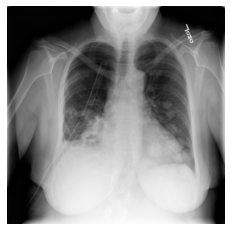

In [0]:
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off')

# Exploring the Data and Labels
Any given patient may potentially have many boxes if there are several different suspicious areas of pneumonia. To collapse the current CSV file dataframe into a dictionary with unique entries, we consider the following method:

In [0]:
def parse_data(df):
    # Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': 'stage_2_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

In [0]:
parsed = parse_data(df)

As we saw above, patient 00436515-870c-4b36-a041-de91049b9ab4 has pnuemonia:

In [0]:
print(parsed['00436515-870c-4b36-a041-de91049b9ab4'])


{'dicom': 'stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm', 'label': 1, 'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]]}


# Visualizing Boxes
In order to overlay color boxes on the original grayscale DICOM files, we consider using the following methods:

In [0]:
def draw(data):
    # Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    # Convert coordinates to integers
    box = [int(b) for b in box]
    
    # Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

As we saw above, patient 00436515-870c-4b36-a041-de91049b9ab4 has pnuemonia so let's take a look at the overlaid bounding boxes:

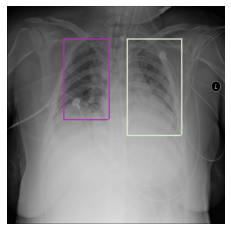

In [0]:
draw(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

# Exploring Detailed Labels
In this challenge, the primary endpoint will be the detection of bounding boxes consisting of a binary classification. However, in addition to the binary classification, each bounding box without pneumonia is further categorized into normal or no lung opacity / not normal. This extra class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image.

As above, we saw that the first patient in the CSV file did not have pneumonia.

In [0]:
df_detailed = pd.read_csv('stage_2_detailed_class_info.csv')
print(df_detailed.iloc[0])


patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
class                No Lung Opacity / Not Normal
Name: 0, dtype: object


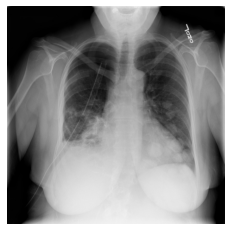

In [0]:
patientId = df_detailed['patientId'][0]
draw(parsed[patientId])

As you can see, there are a number of abnormalities on the image, and the determination that none of these findings correlate to pneumonia is somewhat subjective even among expert physicians. Therefore, as is almost always the case in medical imaging datasets, the provided ground-truth labels are far from 100% objective.

# Label Summary
Finally, let us take a closer look at the distribution of labels in the dataset. To do so we will first parse the detailed label information:

In [0]:
summary = {}
for n, row in df_detailed.iterrows():
    if row['class'] not in summary:
        summary[row['class']] = 0
    summary[row['class']] += 1
    
print(summary)

{'No Lung Opacity / Not Normal': 11821, 'Normal': 8851, 'Lung Opacity': 9555}


After exploring the data, we were able to:

Discover duplications in the tabular data;
Explore the DICOM images;
Extract meta information from the DICOM data;
Add features to the tabular data from the meta information in DICOM data;
urther analyze the distribution of the data with the newly added features from DICOM metadata;